# Feature attribution for explainable AI in vision <mark>Part 1</mark>

In this tutorial, we will try to explain what is happening inside the CNN using feature attribution methods.

**Feature attribution methods** highlight the features or pixels that were relevant for a certain image classification by a neural network.

**Gradient-based:** Many methods compute the gradient of the prediction (or classification score) with respect to the input features. The gradient-based methods (of which there are many) mostly differ in how the gradient is computed.

In this tutorial, you will apply gradient-based feature attribution:
- **saliency mapping**: use gradients to understand what image pixels are most important for classification.
- **GradCam** to understand what areas of the image are important for classification.
- **integrated gradients** for the same purpose.
:
We are making use of the following PyTorch implementations:
- Integrated Gradient blog: https://distill.pub/2020/attribution-baselines/
- Axiomatic Attribution for Deep Networks: https://arxiv.org/pdf/1703.01365.pdf



## Set the environment

We will first load the necessary python libraries.
For google colab, we will connect to google drive. Please store the example files in the datafiles PATH.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
datafiles = 'gdrive/MyDrive/Integrated gradient/' # The folder where the code/datasets and example images are located.
print('data is in: ', datafiles)

Mounted at /content/gdrive
data is in:  gdrive/MyDrive/Integrated gradient/


In [ ]:
# set-up environment
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os  # necessary
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow   # specific for colab

## 1. Load a pretrained CNN model.

We will make use of the VGG19 CNN network and ImageNet.

- ImageNet is a large collection of images.
- VGG19 is a convolutional neural network architecture.
- We can load a version that is trained on ImageNet and that can detect objects in 1000 classes.

- Read about and understand VGG ConvNet and Imagenet for background.

The first step is that using the pytorch library, we load the pretrained version of VGG19.

A Note on use of GPU. For more speed you may use some GPU, e.g. using Lisa. In order to make use to GPU you have to load your data in this specific mode.

Since we will not train the model we set the model in evaluation mode.

- Print and investigate the network structure of the VGG network.
- Mention the three main architectural parts of this VGG network and describe short the purpose of these parts.
- Describe shortly the required dimensions of the input (images) and the dimensions of the output (prediction).

In [ ]:
# load model
# model_type = 'vgg19'
model = models.vgg19(pretrained=True)

# run it on a GPU if available:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('cuda:', cuda, 'device:', device)
model = model.to(device)

# set model to evaluation
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 90.7MB/s]


cuda: True device: cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## 2. Load and preprocess the images

Load an image. We have provided a few images on elephant and sharks, but please also use you own imagery.

VGG-19 works best if image is normalised. Image should also be in the correct tensor format.

--> ensure that input is in correct tensor format. Tip: you can use pytorch method like:

input = torch.tensor(input, dtype=torch.float32, device=torch_device).

(note: we will provide a few images)

In [ ]:
cd/content/gdrive/My Drive/Integrated gradient/images/

/content/gdrive/My Drive/Integrated gradient/images


In [ ]:
def pre_processing(obs, cuda):
    # Students should transpose the image to the correct tensor format.
    # Students should ensure that gradient for input is calculated
    # set the GPU device
    if cuda:
        torch_device = torch.device('cuda:0')
    else:
        torch_device = torch.device('cpu')

    # normalise
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std

    # make tensor format that keeps track of gradient
    # BEGIN for students to do
    obs = np.transpose(obs, (2, 0, 1))
    obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=torch_device)
    # END for students to do
    return obs_tensor

# read the image and convert it
img = cv2.imread('horse.jpg')

img = cv2.resize(img, (224, 224))
img = img.astype(np.float32)
img = img[:, :, (2, 1, 0)]
print('img:', img.shape)

# Preprocess the image
obs_tensor = pre_processing(img, cuda=False)
print('obs_tensor:', obs_tensor.shape)

img: (224, 224, 3)
obs_tensor: torch.Size([1, 3, 224, 224])


## **2. Predict class**

We can now easily predict the class, and the softmax score of that prediction.

In [ ]:
def predict(input, model, target_label_idx, cuda):
    # Student should make prediction after preprocessing image
    # Student should use softmax for getting predicion < 1.
    # Note that output should be torch.tensor on cuda

    output = model(input)
    output = F.softmax(output, dim=1)            # calc output from model

    if target_label_idx is None:
      target_label_idx = torch.argmax(output, 1).item()
    index = np.ones((output.size()[0], 1)) * target_label_idx
    index = torch.tensor(index, dtype=torch.int64)
    if cuda:
      index = index.cuda()                     # calc prediction
    output = output.gather(1, index)           # gather functionality of pytorch
    return target_label_idx, output

# test preprocessing
input = pre_processing(img, cuda)          # preprocess: image (normalise, transpose, make tensor on cuda, requires_grad=True)
output = predict(input, model, None, cuda)
print('output:', output)

output: (222, tensor([[0.3601]], device='cuda:0', grad_fn=<GatherBackward0>))


## **3.1 Visualise Saliency Map**.

Now that we can predict the class of an object, we will try to understand what image pixels are most important for the prediction using *feature Attribution XAI methods*. The first technique that we will make use is the saliency maps. Briefly this approach determines the gradient of the output w.r.t to the input.

The idea of Saliency maps (called "Vanilla Gradient" as well), introduced by Simonyan et al. (https://arxiv.org/pdf/1312.6034.pdf) as one of the first pixel attribution approaches. The core idea is really simple and what needs to be done is to calculate the gradient of the loss function for the class we are interested in with respect to the input features. This gives us a map of the size of the input features with negative to positive values.

The recipe for this approach is as follows:
- **Perform a forward pass** of the image ($\mathbf{x}_0$) of interest using network $\mathcal{F}(\mathbf{x}_0)$.
- **Compute the gradient** of class score of interest with respect to the input pixels ($\mathbf{x}_0$):

$$g(x_o) = \frac{\partial \mathcal{F}}{\partial \mathbf{x}_0} $$.
- **Visualize the gradients**: You can either show the absolute values or highlight negative and positive contributions separately.

**The intructions for the PyTorch code**:

We have set the model in eval mode, but we can still catch the gradients of the input-image if ask PyTorch to do this and then do some backward calculation. That is what you need to do. So complete the procedure in order that:
- Input should be preprocessed (and converted into a torch tensor).
- Set the <mark>required_gradient=True</mark> on the input tensor.
- Calculate the output (with previous method predict).
- Set the gradient to zero and do a backward on the output.
- Gradients w.r.t input can now be found under <mark>input.grad</mark>








# ACTIVITY Fill the missing code

In [ ]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=False):
    # Students have to calculate the gradient of the output w.r.t. the input image
    # The result should be a gradients numpy matrix of same dimensions as the inputs
    predict_idx = None
    gradients = []
    for input in inputs:# for every image

        input = pre_processing(input, cuda)
        input.requires_grad=True
        _, output = predict(input, model, target_label_idx, cuda)
        model.zero_grad()

        # BEGIN students TODO
        output.backward()
        # END students TODO

        gradient = input.grad.detach().cpu().numpy()[0]  # do backward and gather gradients of input
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx

# calculate the gradient and the label index
gradients, label_index = calculate_outputs_and_gradients([img], model, None, cuda)
gradients = np.transpose(gradients[0], (1, 2, 0))

print('gradients', gradients.shape)
print(gradients[:3, :3, 0])

gradients (224, 224, 3)
[[ 3.2814339e-04  4.1704257e-05  5.9772363e-05]
 [ 2.5413083e-04 -4.3914368e-04  1.7868806e-04]
 [-3.4355096e-04  6.3421787e-05 -6.1288453e-04]]


## **3.2 Visualise the saliency map (gradients)**

Try to visualise the image and the saliency map.
**Tip:** take absolute values of the gradients and maximize over all three channels.

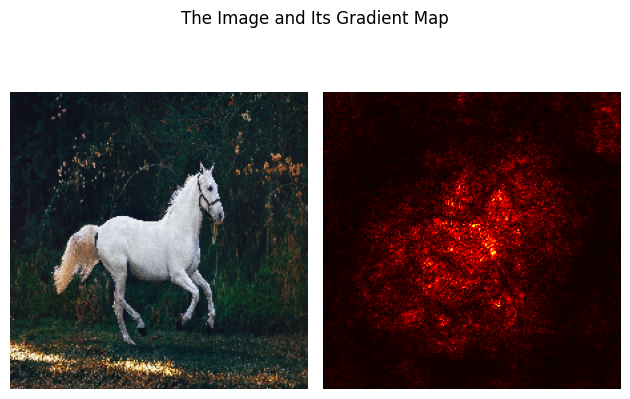

In [ ]:
# Retrieve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=2. Recall the shape of gradients (width, height, channel)

def plot_gradients(img, gradients, title):
  # plots image (dimensions: Width X Heigth X 3) and gradients (dimensions: Width X Heigh x 3) - both numpy arrays
  saliency = np.max(np.abs(gradients), axis=2)       # takes maximum over 3 color channels
  # Visualize the image and the saliency map
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(img/255)
  ax[0].axis('off')
  ax[1].imshow(saliency, cmap='hot')
  ax[1].axis('off')
  plt.tight_layout()
  fig.suptitle(title)
  plt.show()

plot_gradients(img, gradients, 'The Image and Its Gradient Map')

## **3.3 Problems with saliency maps and vanilla gradient (saturation issues)**.

Vanilla Gradient methods, notoriously, are facing saturation problems, as explained in Avanti et al. (2017). When the ReLU is used, and when the activation goes below zero, then, the activation is limited at zero and does not change any more. Hence, the activation is saturated.

## **4 Grad Cam**

Unlike saliency maps, in the **Grad-Cam** approach the gradient is not backpropagated all the way back to the image, but (usually) to the last convolutional layer in order to generate a visualization map that highlights important regions of the input.

A naive visualization approach could be the following:

- Simply employ the values for each feature map, (of the last convolutional layer),
- Then, average these feature maps and overlay this over our image (by rescaling back to initial size).

However, while simple, it is not really helpful approach, since these maps encode information for all classes, while we are interested in a specific class. **Grad-CAM** needs to figure out the importance for each of the $k$ feature map $A_k \in \mathbb{R}^{w \times h}$ ($w$ the width and $h$ the height of the features maps) in respect to our class $c$ of interest.

We have to weight each pixel of each feature map with the gradient before averaging over the feature maps $A_k$. This heatmap is send through the ReLU function which set all negative values to zero. The reason for that is that we are only interested in the parts that contribute to the selected class $c$ and not to other classes. The final feature map is rescaled back to the original image size. We then overlay it over the original image for producing the final visualization.

**Grad Cam recipe:**

- Forward-propagate the input image $\mathbf{x}_0$ through the convolutional VGG19 network by calculating the $\mathcal{F}(\mathbf{x}_0)$.
- Obtain the score for the class of interest, that means the activation before the softmax layer.
- All the rest classes' activations should be set to zero.
- Back-propagate the gradient of the class of interest to the last convolutional layer before the fully connected layers:

$$\frac{\partial y_{c}}{\partial A^k}$$

- Weight each feature map "pixel" by the gradient for the class. Indices $i$ and $j$ refer to the width and height dimensions:

$$\alpha^{c}_{k} = \overbrace{\frac{1}{Z} \sum_i \sum_j}^{\text{global averaging pooling}} \underbrace{\frac{\partial y_{c}}{\partial A^{k}_{ij}}}_{\text{gradients of the backpropagation}}$$

This means that the gradients are globally pooled.

- Calculate an average of the feature maps, weighted per pixel by backpropagated gradient.
- Apply ReLU to the averaged feature map.

$$  L_{ij}^c = ReLU \sum_k \alpha^{c}_{k} A^{k}_{ij}$$

We now have a heatmap $L^c$ for the class $c$.

- Regarding the visualization: Scale values of the $L^c$ to the interval between 0 and 1. Upscale the image and overlay it over the original image.

In our classification example this approach uses the activation map of the final convolutional layer (with VGG: the final features layer). Note that such an Activation Map can be a block of $14 \times 14 \times 512$, where the $14 \times 14$ indicated a grid on the image (noted by subscripts i and j) and the 512 is the number of channels (features, noted by the letter k). **Grad Cam** pools the Activation Map over the channels, and it gives a weight equal to the contribution of each channel to the prediction. This contribution of each channel is calculated by taking the gradient of the output w.r.t. the Activation Map and then pool this over the spacial ($14\times14$) dimensions.

For the calculation of the gradient w.r.t the Activation Map we need a little PyTorch trick since this gradient cannot be accessed by default. The PyTorch trick is called a 'hook'. We can register a hook on a tensor of the network. With a hook we can define a little program that is executed when the tensor is touched during a backward pass. In our case we register a hook on the Activation Map we want to study and that is the 36th layer of the VGG19 convolutional "features" layer. The hook needs to be registered during a forward pass, so we will redefine the forward pass for our model.


There is a nice youtube tutorial on pytorch and hooks https://www.youtube.com/watch?v=syLFCVYua6Q. (22 minutes but I think it is worth it)


## **4.1  Define a new VGG() model including a hook**

The VGG() class is based on the pretrained models.vgg19 that we have already load before.

The <mark>Activation Map</mark> that we want to study should be defined in the init function. That is the output of the first 36 feature layers.

In the <mark>activations_hook</mark> method we should define our hook that will store the gradient calculated on the tensor in <mark>self.gradients</mark>.

In the forward pass, we should execute all VGG layers <em>by hand</em>. The hook is registered on the output of the first 36 feature layers. And then the remaining layers are defined.

Fill the code procedures for accessing the activation maps and gradients w.r.t. these activation maps.

When defined, we load this model, move it to our GPU if available and put the model in eval mode.

# ACTIVITY Fill the code

In [ ]:
class VGG(nn.Module):
    def __init__(self, model):
        super(VGG, self).__init__()

        # get the pretrained VGG19 network
        self.vgg = models.vgg19(pretrained=True)
        # self.vgg = model

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations: it stores the calculated grad (on our tensor) in self.gradients.
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        # gives the output of the first 36 'feature' layers
        x = self.features_conv(x)

        # register the hook (note: h is a handle, giving the hook a identifier, we do not use it here)
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))

        # apply the remaining classifying
        x = self.classifier(x)

        return x

    # method for the gradient extraction
    def get_activations_gradient(self):

        # BEGIN students TODO
        return self.gradients
        # END students TODO

    # method for the activation exctraction
    def get_activations(self, x):

        # BEGIN students TODO
        return self.features_conv(x)
        # END students TODO

vgg = VGG(model)
print('cuda:', cuda, 'device:', device)
vgg = vgg.to(device)
vgg.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda: True device: cuda:0


VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv2d

## 4.2 Now calculate the gradients of a prediction w.r.t. the activation map.

We should perform a prediction with our newly defined model <mark>vgg</mark>, and perform a backward on the output (the logit of the prediction vector that is largest). After the backward, the gradients w.r.t the activation map are stored in self.gradient

In [ ]:
# get the most likely prediction of the model

input = pre_processing(img, cuda)          # preprocess: image (normalise, transpose, make tensor on cuda, requires_grad=True)
print(input.shape)

pred, output = predict(input, vgg, None, cuda)
print(pred, output)                        # prediction gives class 2 = shark, or 386 = elephant
                                           # maybe work with softmax here too

torch.Size([1, 3, 224, 224])
222 tensor([[0.3601]], device='cuda:0', grad_fn=<GatherBackward0>)


In [ ]:
# get the gradient of the output with respect to the parameters of the model
output.backward()

# ACTIVITY fille the code (Calculate the pooled gradient for each channel and return it in a variable pooled_gradients)

gradients: torch.Size([1, 512, 14, 14])
pooled gradients: torch.Size([512])
heatmap: torch.Size([14, 14])


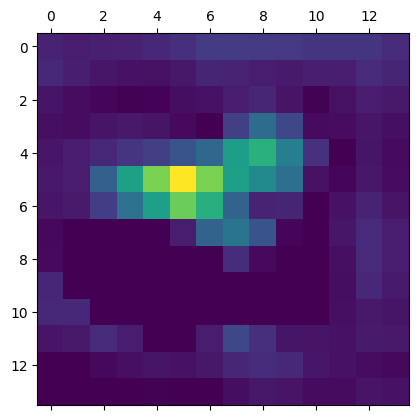

In [ ]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
print('gradients:', gradients.shape)

# pool the gradients across the channels

# BEGIN TODO
# Calculate the gradient weint and return it in a variable pooled_gradients
pooled_gradients = torch.mean(gradients, dim=(0, 2, 3))
# END TODO

print('pooled gradients:', pooled_gradients.shape)

# get the activations of the last convolutional layer
activations = vgg.get_activations(input).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
# heatmap = np.maximum(heatmap, 0)
heatmap = torch.maximum(heatmap, torch.tensor(0))

# normalize the heatmap
heatmap /= torch.max(heatmap)

print('heatmap:', heatmap.shape)

# draw the heatmap
heatmap = heatmap.cpu().numpy().squeeze()
plt.matshow(heatmap)

img: (224, 224, 3)


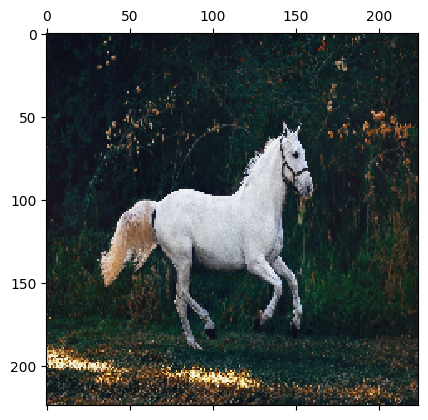

In [ ]:
# draw the image
print('img:', img.shape)
plt.matshow(img/255)


(224, 224, 3) (14, 14)
(224, 224, 3) 0.0 255.0
(224, 224, 3) 0 255


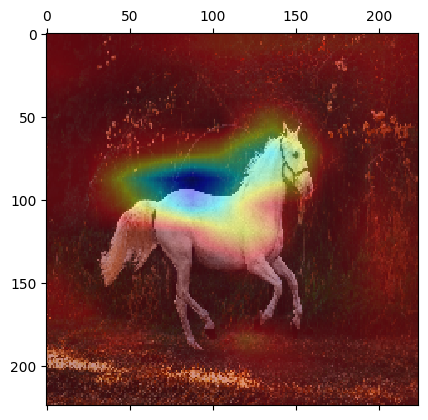

In [ ]:

print(img.shape, heatmap.shape)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

print(img.shape, img.min(), img.max())
print(heatmap.shape, heatmap.min(), heatmap.max())

super_img = heatmap * 0.4 + img * 0.6
super_img = np.uint8(super_img)
plt.matshow(super_img)

#**5. Integrated gradient**

Path-attribution methods compare the current image to a reference image, which can be an artificial <em>zero<.em> image such as a completely black image or random noise image. The difference in actual and baseline prediction is divided among the pixels.

Now, let us consider the linear path between the baseline $\mathbf{x}^{'}$ (black image or random noise) and our input image $\mathbf{x}$ and compute all the points along this path using variable $a$. Integrated gradients are obtained by cumulating these gradients between the initial image and the gradual difference between the initial image and the baseline.

Specifically, integrated gradients are defined as the path intergral of the gradients along the straightline path from the baseline $\mathbf{x}^{'}$ to the input $\mathbf{x}$.

The integral gradient for the $k^{\text{th}}$ for an input $\mathbf{x}$ and baseline $\mathbf{x}^{'}$ is defined as:

$$
IG_k(\mathbf{x}) =  \underbrace{({x}_i - {x}^{'}_i)}_{\text{Difference from baseline}} \overbrace{\int_{a=0}^{1} \frac{\partial \mathcal{F}( {\mathbf{x}}^{'} + a\times (\mathbf{x} -\mathbf{x}^{'}) )}{\partial x_i} \,da}^{\text{Accumulated  local gradients}}
$$

The baseline $\mathbf{x}^{'}$  represents <mark>absence</mark> of feature input.

If we have a closer look in the above equation, IG accumulates gradients on images interpolated between the baseline value and the current input.

**But why would doing this make sense?** Recall that the gradient of a function represents the direction of maximum increase. The gradient is telling us which pixels have the steepest local slope with respect to the output. For this reason, the gradient of a network at the input was one of the earliest saliency methods.

But using only the gradients for the visualization can lead to saturation problems. The gradients of input features may have small magnitudes around a sample even if the network depends heavily on those features. This can happen if the network function flattens after those features reach a certain magnitude. Intuitively, shifting the pixels in an image by a small amount typically doesn’t change what the network sees in the image.

Hence, in IG, we really want to know is how our network got from predicting essentially nothing at $\mathbf{x}^{'}$ to being completely saturated towards the correct output class at $\mathbf{x}$. Which pixels, when scaled along this path, most increased the network output for the correct class? This is exactly what the formula for integrated gradients gives us.

By integrating over a path, integrated gradients avoids problems with local gradients being saturated. We can break the original equation down and visualize it in three separate parts: the interpolated image between the baseline image and the target image, the gradients at the interpolated image, and accumulating many such gradients over $\alpha$.

Fortunately, instead of calculating the integral of integrated gradients we can approximate it via a summation. We can calculate it through the following equation:

$$
IG_k(\mathbf{x}) =  ({x}_i - {x}^{'}_i) \times  {\sum_{K=1}^{m} \frac{\partial F( \mathbf{x}^{'} + \frac{k}{m}\times (\mathbf{x} - \mathbf{x}^{'}) )}{\partial x_i} \times \frac{1}{m}}
$$

IG approach satisfies the two following axioms:

## **5.1 Calculate Integrated Gradients recipe**.

Read first the literature on Integrated Gradients.

Instructions for students:
Read the provided articles. We will approximate the integrated gradient by the Rieman summation. So:
  - **Choose a baseline image**. For this purpose we choose a all black image.
  - **Build a series of inputs**, each input consist of the baseline plus an additional fraction of the inputimage. The final input is the baseline plus the full image. Choose your fraction at 20.
  - For each of these inputs, **calculate the gradients of the input** w.r.t. the prediction (using methods under 2 above). Take the average of all these gradients.
  - **Calculate the difference of image and baseline**: I-B. And calculate Integrated Gradient = (I-B)*average of gradients.
  - If you have chosen for another baseline, e.g. for a uniform random generated baseline, then perform this procedure for multiple samples.



In [ ]:
# integrated gradients
def integrated_gradients(inputs, model, target_label_idx, baseline, steps=50, cuda=False):

    # determine baseline
    if baseline is None:
        baseline = 0 * inputs
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = calculate_outputs_and_gradients(scaled_inputs, model, target_label_idx, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.transpose(avg_grads, (1, 2, 0))
    delta_X = (pre_processing(inputs, cuda) - pre_processing(baseline, cuda)).detach().squeeze(0).cpu().numpy()
    delta_X = np.transpose(delta_X, (1, 2, 0))
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, target_label_idx, steps, num_random_trials, cuda=False):
    # when baseline randomly generated, take some samples and average result
    all_intgrads = []
    random_baseline = 255.0 * np.random.random(inputs.shape)
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, target_label_idx, baseline=random_baseline, steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
        print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

# calculate the integrated gradients
print('img:', img.shape, 'label_index', label_index)

# for zero baseline
int_gradients_zerobl = integrated_gradients(img, model, label_index, baseline=None, steps=50, cuda=cuda)
print('DONE')
# for random baselines, we average over number of trials
int_gradients_randombl = random_baseline_integrated_gradients(img, model, label_index, steps=50, num_random_trials=5, cuda=cuda)
print('DONE')

img: (224, 224, 3) label_index None
DONE
the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
DONE


##**Visualise the integrated gradients**

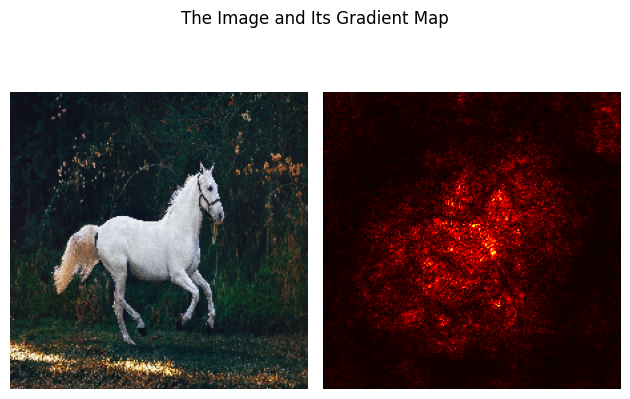

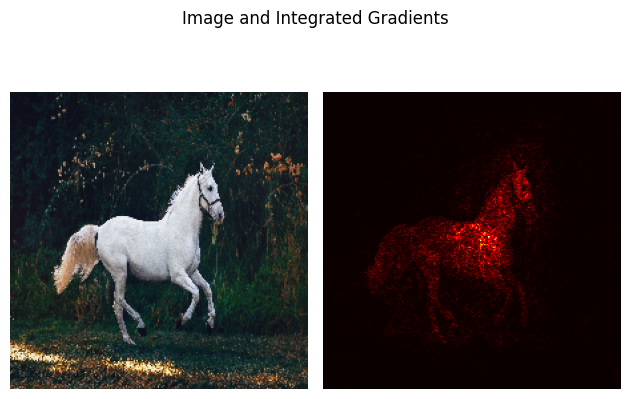

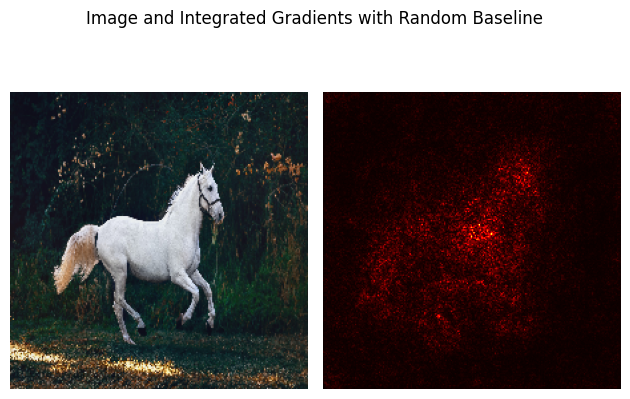

In [ ]:
# visualise overall

# calculate gradients
gradients, _ = calculate_outputs_and_gradients([img], model, None, cuda)
gradients = np.transpose(gradients[0], (1, 2, 0))

# combine it all in one image
plot_gradients(img, gradients, 'The Image and Its Gradient Map')
plot_gradients(img, int_gradients_zerobl, 'Image and Integrated Gradients')
plot_gradients(img, int_gradients_randombl, 'Image and Integrated Gradients with Random Baseline')

## By the way - I do not trust the results very much - integrated gradients seem to focus on pixels just above the elephants


# **Homework-part 1 <mark>TOSUBMIT</mark>**.

Work for home:
  - Read the main article for IG
  -  Why integraded gradients give better results than the other saliency methods?
  - Think about what us the role of the baseline and how it impacts negatively the reults.
  - Which alternative baselines are more efficient than the black or random baseline? Write down the reasons for that.

   <mark>TOSUBMIT</mark> At your first paragraph of your report you should analyze this.


